**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

**Note**: You may find little differences between the code outputs in the book and in these Jupyter notebooks: these slight differences are mostly due to the random nature of many training algorithms: although I have tried to make these notebooks' outputs as constant as possible, it is impossible to guarantee that they will produce the exact same output on every platform. Also, some data structures (such as dictionaries) do not preserve the item order. Finally, I fixed a few minor bugs (I added notes next to the concerned cells) which lead to slightly different results, without changing the ideas presented in the book.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Get the data

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


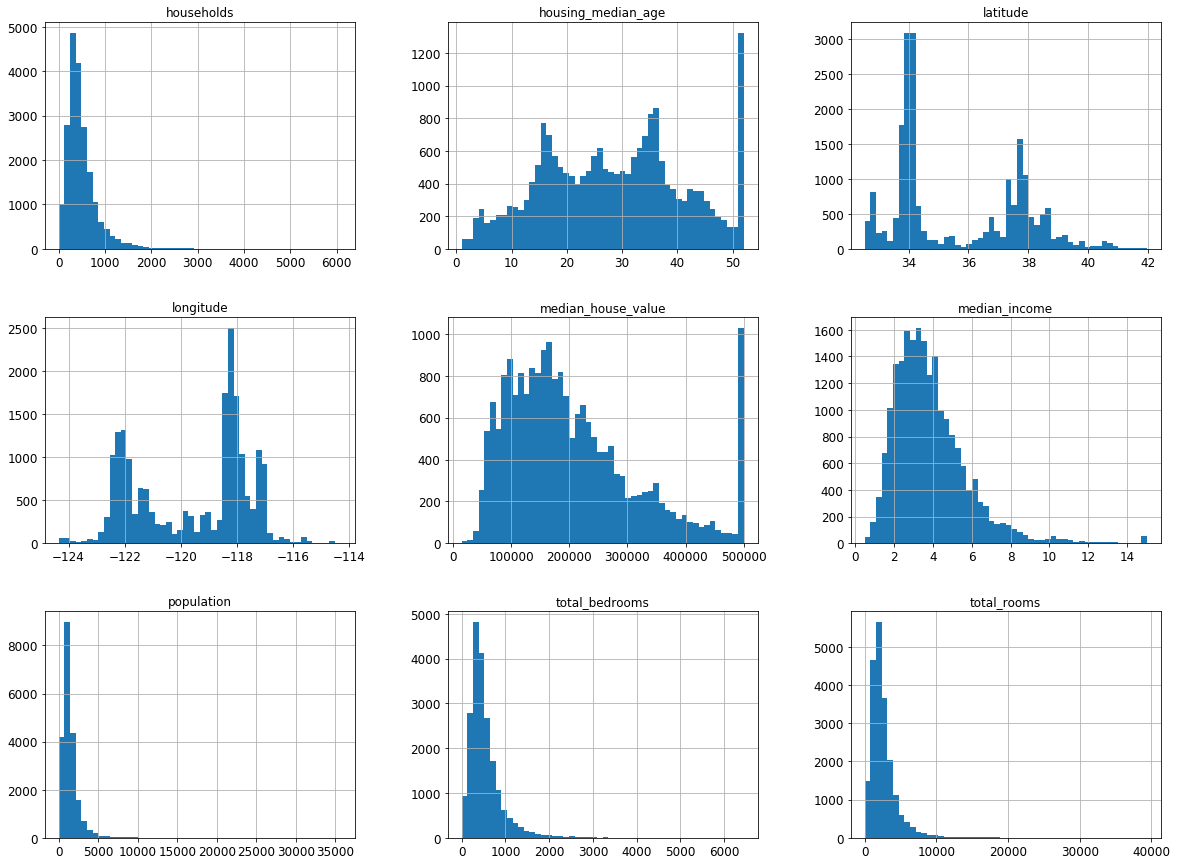

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [11]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [13]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
# This version supports both Python 2 and Python 3, instead of just Python 3.
def test_set_check(identifier, test_ratio, hash):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [15]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [16]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [17]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [18]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [19]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


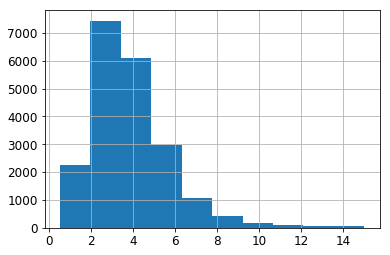

In [20]:
housing["median_income"].hist()

In [21]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [22]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

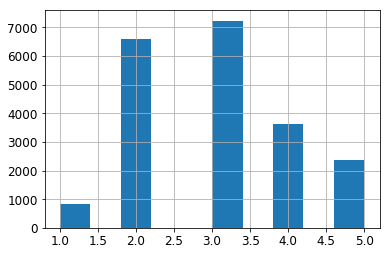

In [23]:
housing["income_cat"].hist()

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [25]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [26]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [27]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and visualize the data to gain insights

In [29]:
housing = strat_train_set.copy()

Saving figure bad_visualization_plot


FileNotFoundError: [Errno 2] No such file or directory: '.\\images\\end_to_end_project\\bad_visualization_plot.png'

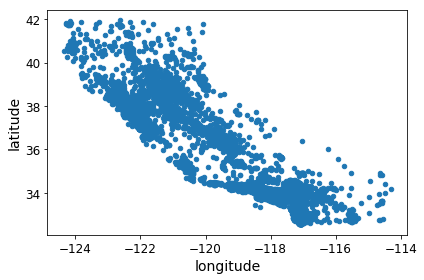

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


FileNotFoundError: [Errno 2] No such file or directory: '.\\images\\end_to_end_project\\better_visualization_plot.png'

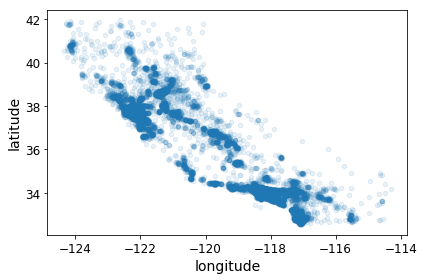

In [31]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

Saving figure housing_prices_scatterplot


FileNotFoundError: [Errno 2] No such file or directory: '.\\images\\end_to_end_project\\housing_prices_scatterplot.png'

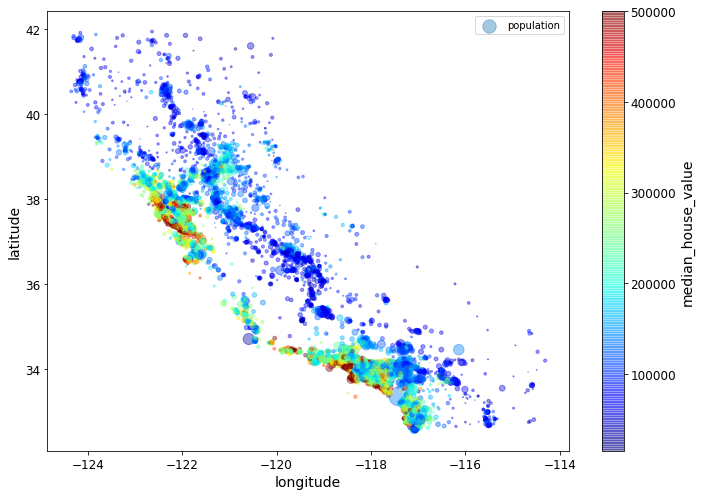

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [ ]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [34]:
corr_matrix = housing.corr()

In [35]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


FileNotFoundError: [Errno 2] No such file or directory: '.\\images\\end_to_end_project\\scatter_matrix_plot.png'

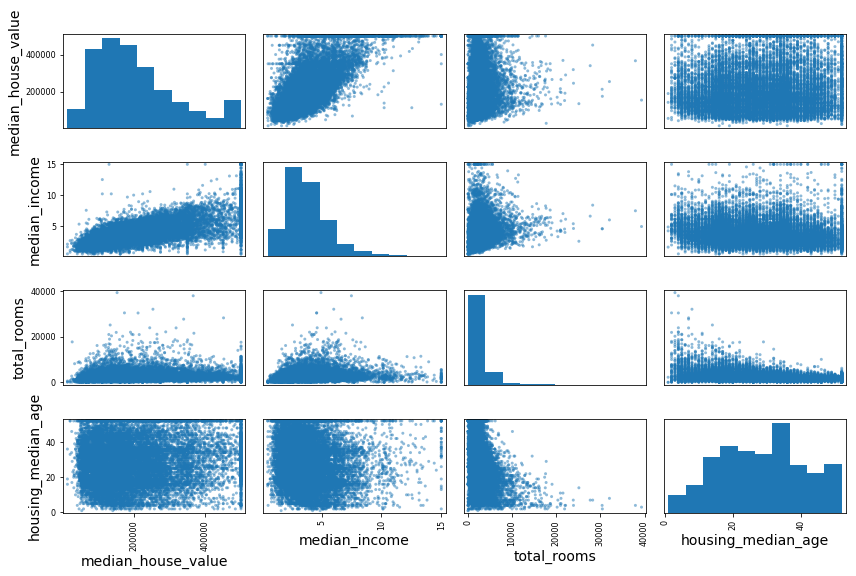

In [36]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

In [42]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Note: there was a bug in the previous cell, in the definition of the `rooms_per_household` attribute. This explains why the correlation value below differs slightly from the value in the book (unless you are reading the latest version).

In [43]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

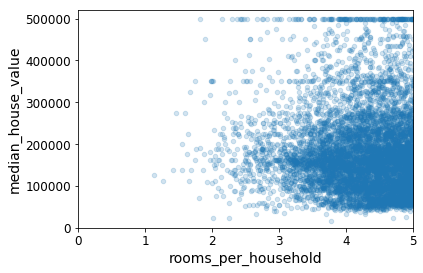

In [44]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [45]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the data for Machine Learning algorithms

In [46]:
housing = strat_train_set.drop("median_house_value", axis=1)
# drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [47]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [48]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [49]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [50]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [51]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [52]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [53]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [54]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

Check that this is the same as manually computing the median of each attribute:

In [55]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

Transform the training set:

In [56]:
X = imputer.transform(housing_num)

In [57]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [58]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [59]:
imputer.strategy

'median'

In [60]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


Now let's preprocess the categorical input feature, `ocean_proximity`:

In [61]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

We can use Pandas' `factorize()` method to convert this string categorical feature to an integer categorical feature, which will be easier for Machine Learning algorithms to handle:

In [62]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0], dtype=int64)

In [63]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

**Warning**: earlier versions of the book used the `LabelEncoder` class instead of Pandas' `factorize()` method. This was incorrect: indeed, as its name suggests, the `LabelEncoder` class was designed for labels, not for input features. The code worked because we were handling a single categorical input feature, but it would break if you passed multiple categorical input features.

We can convert each categorical value to a one-hot vector using a `OneHotEncoder`:

In [64]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The `OneHotEncoder` returns a sparse array by default, but we can convert it to a dense array if needed:

In [65]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

**Warning**: earlier versions of the book used the `LabelBinarizer` class at this point. Again, this was incorrect: just like the `LabelEncoder` class, the `LabelBinarizer` class was designed to preprocess labels, not input features. A better solution is to use Scikit-Learn's upcoming `CategoricalEncoder` class: it will soon be added to Scikit-Learn, and in the meantime you can use the code below (copied from [Pull Request #9151](https://github.com/scikit-learn/scikit-learn/pull/9151)).

In [66]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

The `CategoricalEncoder` expects a 2D array containing one or more categorical input features. We need to reshape `housing_cat` to a 2D array:

In [67]:
#from sklearn.preprocessing import CategoricalEncoder # in future versions of Scikit-Learn

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The default encoding is one-hot, and it returns a sparse array. You can use `toarray()` to get a dense array:

In [68]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

Alternatively, you can specify the encoding to be `"onehot-dense"` to get a dense matrix rather than a sparse matrix:

In [69]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [70]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)]

Let's create a custom transformer to add extra attributes:

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [72]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


Now let's build a pipeline for preprocessing the numerical attributes:

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [85]:
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
19480,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395
8879,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839
13685,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000
4937,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999


And a transformer to just select a subset of the Pandas DataFrame columns:

In [75]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [76]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [77]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [78]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [79]:
housing_prepared.shape

(16512, 16)

# Select and train a model 

In [80]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [81]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print(some_data_prepared.shape)

print("Predictions:", lin_reg.predict(some_data_prepared))

(5, 16)
Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]


Compare against the actual values:

In [82]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [83]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [84]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# Fine-tune your model

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

The best hyperparameter combination found:

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

# Extra material

## A full pipeline with both preparation and prediction

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

## Model persistence using joblib

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercise solutions

## 1.

Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [ ]:
grid_search.best_params_

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Question: Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy-0.19.0/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [ ]:
rnd_search.best_params_

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [ ]:
k = 5

Now let's look for the indices of the top k features:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

In [ ]:
np.array(attributes)[top_k_feature_indices]

Let's double check that these are indeed the top k features:

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [ ]:
housing_prepared_top_k_features[0:3]

Now let's double check that these are indeed the top k features:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

Works great!  :)

## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Let's try the full pipeline on a few instances:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Question: Automatically explore some preparation options using `GridSearchCV`.

In [ ]:
param_grid = [
        {'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': [3, 4, 5, 6, 7]}
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

In [ ]:
grid_search_prep.best_params_

Great! It seems that we had the right imputer strategy (mean), and apparently only the top 7 features are useful (out of 9), the last 2 seem to just add some noise.

In [ ]:
housing.shape

Congratulations! You already know quite a lot about Machine Learning. :)